# **Self-Supervised Audio Representation Learning Pipeline**

In [1]:
!pip install -q librosa numpy pandas scikit-learn matplotlib tqdm

In [2]:
import librosa
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
!pip install -q kagglehub

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [120]:
import os

SAFE_BASE = "/content/drive/MyDrive/Impulse2026_SSL"
DATA_DIR = f"{SAFE_BASE}/data"

os.makedirs(DATA_DIR, exist_ok=True)

print("Safe base created at:", DATA_DIR)

Safe base created at: /content/drive/MyDrive/Impulse2026_SSL/data


In [8]:

SAFE_AUDIO_PATH = f"{DATA_DIR}/fma_small/fma_small"
print("Exists:", os.path.exists(SAFE_AUDIO_PATH))
print("Sample folders:", sorted(os.listdir(SAFE_AUDIO_PATH))[:5])

Exists: True
Sample folders: ['000', '001', '002', '003', '004']


In [9]:
audio_root = SAFE_AUDIO_PATH
print("LOCKED audio root:", audio_root)


LOCKED audio root: /content/drive/MyDrive/Impulse2026_SSL/data/fma_small/fma_small


In [10]:

audio_root = "/content/drive/MyDrive/Impulse2026_SSL/data/fma_small/fma_small"

In [11]:
import os

folders = sorted(os.listdir(audio_root))
first_folder = folders[0]

files = sorted(os.listdir(os.path.join(audio_root, first_folder)))
sample_audio_path = os.path.join(audio_root, first_folder, files[0])

sample_audio_path

'/content/drive/MyDrive/Impulse2026_SSL/data/fma_small/fma_small/000/000002.mp3'

In [12]:
import librosa
import numpy as np

signal, sr = librosa.load(sample_audio_path, sr=22050)

print("Sample rate:", sr)
print("Signal shape:", signal.shape)
print("Duration (seconds):", len(signal) / sr)

Sample rate: 22050
Signal shape: (660984,)
Duration (seconds): 29.976598639455784


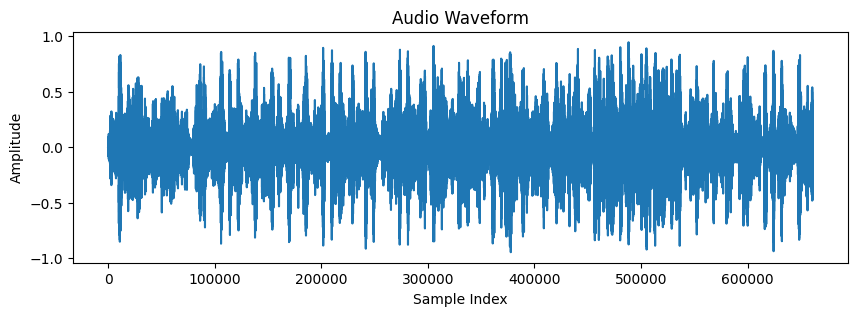

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(signal)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# **Step-5 MFCC**

In [14]:
import librosa

mfcc = librosa.feature.mfcc(
    y=signal,
    sr=sr,
    n_mfcc=40
)

print("MFCC shape:", mfcc.shape)

MFCC shape: (40, 1291)


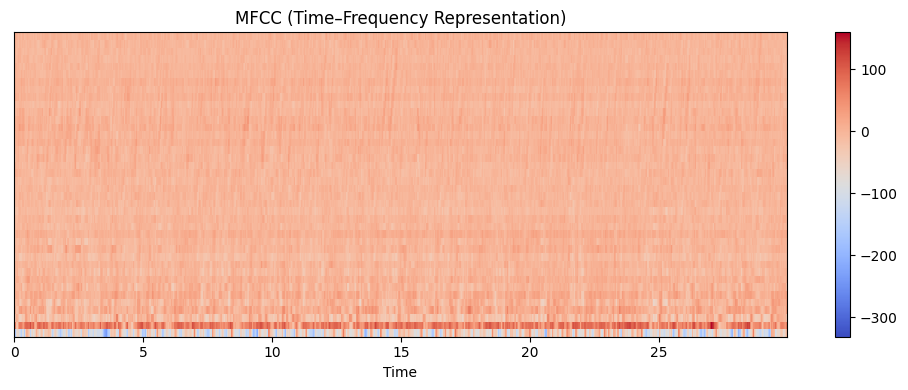

In [15]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis="time")
plt.colorbar()
plt.title("MFCC (Time–Frequency Representation)")
plt.tight_layout()
plt.show()


# **STEP 6 — Convert variable-length MFCC → fixed-size embedding**

In [16]:

import numpy as np

mfcc_mean = np.mean(mfcc, axis=1)

print("MFCC original shape:", mfcc.shape)
print("After mean pooling:", mfcc_mean.shape)


MFCC original shape: (40, 1291)
After mean pooling: (40,)


In [34]:

mfcc_std = np.std(mfcc, axis=1)

embedding = np.concatenate([mfcc_mean, mfcc_std])

print("Final embedding shape:", embedding.shape)

Final embedding shape: (80,)


# **STEP 7 — Apply this embedding extraction to MULTIPLE audio files**

In [18]:

import librosa
import numpy as np

def extract_embedding(audio_path, sr=22050, n_mfcc=40):
    signal, _ = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    embedding = np.concatenate([mfcc_mean, mfcc_std])
    return embedding

In [19]:
BASE_AUDIO_PATH = "/content/drive/MyDrive/Impulse2026_SSL/data/fma_small/fma_small"

In [20]:
audio_files = []

for folder in sorted(os.listdir(BASE_AUDIO_PATH)):
    folder_path = os.path.join(BASE_AUDIO_PATH, folder)

    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.endswith(".mp3"):
            audio_files.append(os.path.join(folder_path, file))

print("Total audio files found:", len(audio_files))
print("Sample file:", audio_files[0])

Total audio files found: 8000
Sample file: /content/drive/MyDrive/Impulse2026_SSL/data/fma_small/fma_small/000/000002.mp3


In [21]:
sample_files = audio_files[:1291]

In [22]:

embeddings = []

for path in sample_files:
    emb = extract_embedding(path)
    embeddings.append(emb)

X = np.array(embeddings)

print("Embedding matrix shape:", X.shape)
print("Mean:", X.mean())
print("Std:", X.std())

Embedding matrix shape: (1291, 80)
Mean: 4.094213
Std: 26.30422


# **STEP 8 — Normalize the embedding matrix**

In [23]:
print([name for name in globals() if 'embed' in name.lower() or 'X' == name])

['embedding', 'extract_embedding', 'embeddings', 'X']


In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np

embedding_matrix = X   # LOCK THIS

scaler = StandardScaler()
X_norm = scaler.fit_transform(embedding_matrix)

print("Shape:", X_norm.shape)
print("Mean:", np.mean(X_norm))
print("Std:", np.std(X_norm))

Shape: (1291, 80)
Mean: 5.9096783e-10
Std: 1.0


# **STEP 9 — SSL AUGMENTATION**

In [72]:
import numpy as np

def augment_embedding(x, noise_std=0.1, drop_prob=0.07):
    x_aug = x.copy()
    x_aug += np.random.normal(0, noise_std, size=x.shape)
    mask = np.random.rand(*x.shape) > drop_prob
    x_aug *= mask
    return x_aug


In [73]:
x = X_norm[0]

x1 = augment_embedding(x)
x2 = augment_embedding(x)

from numpy.linalg import norm
cos_sim = np.dot(x1, x2) / (norm(x1) * norm(x2))

print("Cosine similarity:", cos_sim)

Cosine similarity: 0.84264374


# **STEP 10 — Define the Neural Encoder (MLP)**

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [75]:
class AudioEncoder(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=128, output_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        z = self.net(x)
        z = F.normalize(z, dim=1)  # critical for cosine-based SSL
        return z

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioEncoder().to(device)
print(model)

AudioEncoder(
  (net): Sequential(
    (0): Linear(in_features=80, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
)


In [77]:
x_test = torch.tensor(X_norm[:4], dtype=torch.float32).to(device)

with torch.no_grad():
    z_test = model(x_test)

print("Input:", x_test.shape)
print("Output:", z_test.shape)
print("Norms:", torch.norm(z_test, dim=1))

Input: torch.Size([4, 80])
Output: torch.Size([4, 32])
Norms: tensor([1., 1., 1., 1.])


# **STEP 11 — Define the Contrastive Loss (SSL Learning Signal)**

In [78]:
def contrastive_loss(z1, z2, temperature=0.1):
    """
    z1, z2: (batch_size, embedding_dim)
    """
    batch_size = z1.size(0)

    # Similarity matrix
    sim_matrix = torch.matmul(z1, z2.T) / temperature

    # Positive pairs are on the diagonal
    labels = torch.arange(batch_size).to(z1.device)

    loss = F.cross_entropy(sim_matrix, labels)
    return loss

In [79]:

x_batch = torch.tensor(X_norm[:8], dtype=torch.float32).to(device)

x1 = torch.stack([
    torch.tensor(augment_embedding(x.cpu().numpy()), dtype=torch.float32)
    for x in x_batch
]).to(device)

x2 = torch.stack([
    torch.tensor(augment_embedding(x.cpu().numpy()), dtype=torch.float32)
    for x in x_batch
]).to(device)

z1 = model(x1)
z2 = model(x2)

loss = contrastive_loss(z1, z2)
print("Contrastive loss:", loss.item())

Contrastive loss: 0.44179317355155945


# **STEP 12 — Full SSL Training Loop**

In [80]:
from torch.utils.data import Dataset, DataLoader

class SSLAudioDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x1 = augment_embedding(x)
        x2 = augment_embedding(x)
        return (
            torch.tensor(x1, dtype=torch.float32),
            torch.tensor(x2, dtype=torch.float32)
        )

In [83]:

dataset = SSLAudioDataset(X_norm)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

print("Batches per epoch:", len(dataloader))

Batches per epoch: 40


In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [85]:
epochs = 15
model.train()

for epoch in range(epochs):
    total_loss = 0.0

    for x1, x2 in dataloader:
        x1 = x1.to(device)
        x2 = x2.to(device)

        z1 = model(x1)
        z2 = model(x2)

        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

Epoch [1/15] - Avg Loss: 0.1955
Epoch [2/15] - Avg Loss: 0.0755
Epoch [3/15] - Avg Loss: 0.0600
Epoch [4/15] - Avg Loss: 0.0528
Epoch [5/15] - Avg Loss: 0.0519
Epoch [6/15] - Avg Loss: 0.0515
Epoch [7/15] - Avg Loss: 0.0429
Epoch [8/15] - Avg Loss: 0.0415
Epoch [9/15] - Avg Loss: 0.0413
Epoch [10/15] - Avg Loss: 0.0355
Epoch [11/15] - Avg Loss: 0.0366
Epoch [12/15] - Avg Loss: 0.0369
Epoch [13/15] - Avg Loss: 0.0338
Epoch [14/15] - Avg Loss: 0.0302
Epoch [15/15] - Avg Loss: 0.0325


In [121]:
import os

# CHECKPOINT 1 — end of Phase 2
output_dir = "/content/drive/MyDrive/Impulse2026/weights"
os.makedirs(output_dir, exist_ok=True)

torch.save(
    model.state_dict(),
    os.path.join(output_dir, "encoder_final.pth")
)



---



# **STEP 12.5 — Phase 3: Retrieval (Shazam Test)**

In [130]:
#Loaded Trained Encoder
model.load_state_dict(torch.load(
    "/content/drive/MyDrive/Impulse2026/weights/encoder_final.pth"
))
model.eval()

def get_audio_model_embedding(audio_path, model, scaler_obj, device_obj):
    # 1. Extract raw MFCC embedding
    raw_embedding = extract_embedding(audio_path)

    # 2. Normalize using the trained scaler
    normalized_embedding = scaler_obj.transform(raw_embedding.reshape(1, -1))

    # 3. Pass through the trained model
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        tensor_embedding = torch.tensor(normalized_embedding, dtype=torch.float32).to(device_obj)
        final_embedding = model(tensor_embedding).cpu().numpy().flatten()
    return final_embedding

print("Helper function `get_audio_model_embedding` defined.")

Helper function `get_audio_model_embedding` defined.


In [ ]:
torch.save(
    database,
    "/content/drive/MyDrive/Impulse2026/weights/database_embeddings.pt"
)
audio_files_phase3 = audio_files[:200]

from tqdm import tqdm
import os

# Re-populate the database with model-generated embeddings
print("Re-populating database with model-generated embeddings...")
database_model_embeddings = {}
model.eval() # Ensure model is in eval mode for inference

# audio_files_phase3 is already defined in mQEcKLrxVZ7l
for path in tqdm(audio_files_phase3, desc="Building model embedding database"):
    track_id = os.path.basename(path)
    # Use global scaler and device, which are assumed to be available after previous cells' execution
    model_emb = get_audio_model_embedding(path, model, scaler, device)
    database_model_embeddings[track_id] = model_emb

# Overwrite the old database with the new one
database = database_model_embeddings
print(f"Database re-populated with {len(database)} model embeddings, shape of first: {next(iter(database.values())).shape}")

Re-populating database with model-generated embeddings...


Building model embedding database: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]

Database re-populated with 200 model embeddings, shape of first: (32,)


In [126]:
#retrival Function
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

def predict_track(query_audio_path, model, database_embeddings_dict):

    query_model_embedding = get_audio_model_embedding(query_audio_path, model, scaler, device)
    best_id, best_score = None, -1.0

    for track_id, db_model_embedding in database_embeddings_dict.items():

        score = cosine_similarity(query_model_embedding.reshape(1, -1), db_model_embedding.reshape(1, -1))[0][0]
        if score > best_score:
            best_score, best_id = score, track_id

    return best_id, best_score

In [125]:
# sanity test
test_id, test_score = predict_track(audio_files_phase3[0], model, database)
print("Predicted track:", test_id)
print("Similarity score:", test_score)

Predicted track: 000002.mp3
Similarity score: 1.0000001


# **STEP 13 — Generate FINAL Learned Embeddings**

In [114]:
model.eval()
for p in model.parameters():
    p.requires_grad = False


In [87]:
import numpy as np

final_embeddings = []

with torch.no_grad():
    for i in range(0, len(X_norm), 32):
        batch = torch.tensor(
            X_norm[i:i+32],
            dtype=torch.float32
        ).to(device)

        z = model(batch)
        final_embeddings.append(z.cpu().numpy())

final_embeddings = np.vstack(final_embeddings)

print("Final embedding matrix shape:", final_embeddings.shape)

Final embedding matrix shape: (1291, 32)


In [88]:
print("Mean:", np.mean(final_embeddings))
print("Std:", np.std(final_embeddings))
print("Any NaN:", np.isnan(final_embeddings).any())

Mean: -0.00060131453
Std: 0.17677568
Any NaN: False


# **STEP - 14 OUTPUT CSV- download**

In [127]:

import pandas as pd
import os

df = pd.DataFrame(final_embeddings)
df.insert(0, "audio_id", audio_ids)

df.to_csv("outputs.csv", index=False)
print("outputs.csv saved with shape:", df.shape)

outputs.csv saved with shape: (1291, 33)


In [94]:
pd.read_csv("outputs.csv").head()

,audio_id,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,000002.mp3,-0.134546,-0.203144,-0.112648,-0.165240,0.198168,0.025838,0.287654,-0.028808,-0.050204,...,-0.090983,0.317081,0.251757,-0.012939,-0.211842,-0.126510,-0.129348,-0.483498,0.018453,-0.114290
1,000005.mp3,-0.079768,0.061186,0.150750,-0.287016,0.183859,0.076505,0.108031,0.211313,0.034009,...,-0.317580,0.427251,-0.109436,-0.206771,-0.109308,-0.262877,0.112738,-0.184598,0.230005,-0.157471
2,000010.mp3,-0.012335,-0.102070,-0.077606,0.098091,0.304376,0.166140,-0.016884,0.219623,-0.332840,...,-0.070334,-0.004720,-0.057896,-0.187673,-0.072459,-0.037344,0.205653,0.094696,-0.394854,0.152230
3,000140.mp3,-0.053597,0.236146,0.161285,-0.194873,-0.260485,0.066552,0.129362,0.428730,-0.173821,...,-0.047097,0.027309,0.087803,-0.008124,0.044391,-0.110676,-0.209026,0.229265,0.079742,0.256740
4,000141.mp3,0.080411,0.277191,0.012166,-0.165974,-0.111288,-0.214607,0.172267,0.050671,0.091603,...,-0.054698,-0.367172,-0.083327,-0.299882,0.101643,0.160854,0.007950,-0.190199,-0.150482,-0.019141


In [129]:
#save to drive
import pandas as pd

rows = []
for track_id, emb in database.items():
    row = {"track_id": track_id}
    for i, val in enumerate(emb.tolist()):
        row[f"emb_{i}"] = val
    rows.append(row)

df = pd.DataFrame(rows)
csv_path = "/content/drive/MyDrive/Impulse2026/outputs.csv"
df.to_csv(csv_path, index=False)

print("CSV saved at:", csv_path)


CSV saved at: /content/drive/MyDrive/Impulse2026/outputs.csv




---



# **Phase 4: Semantic Utility Verification**


*This section evaluates whether the learned SSL embeddings capture meaningful semantic structure. We use PCA visualization and similarity analysis to verify clustering and invariance.*





# **Load embeddings**

In [100]:
import pandas as pd
import numpy as np

df = pd.read_csv("outputs.csv")

audio_ids = df.iloc[:, 0].values
embeddings = df.iloc[:, 1:].values

print("Total samples:", embeddings.shape[0])
print("Embedding dimension:", embeddings.shape[1])

Total samples: 1291
Embedding dimension: 32


# **Cosine similarity retrieval**

In [101]:
from sklearn.metrics.pairwise import cosine_similarity

# pick a query
query_idx = 0
query_embedding = embeddings[query_idx].reshape(1, -1)

# compute similarity
similarities = cosine_similarity(query_embedding, embeddings)[0]

# top-5 most similar (excluding itself)
top_k = similarities.argsort()[::-1][1:6]

print("Query audio:", audio_ids[query_idx])
print("\nTop 5 similar audios:")
for idx in top_k:
    print(audio_ids[idx], "-> similarity:", round(similarities[idx], 3))

Query audio: 000002.mp3

Top 5 similar audios:
026902.mp3 -> similarity: 0.655
024701.mp3 -> similarity: 0.646
020469.mp3 -> similarity: 0.644
015476.mp3 -> similarity: 0.623
019729.mp3 -> similarity: 0.596


# **PCA visualization**

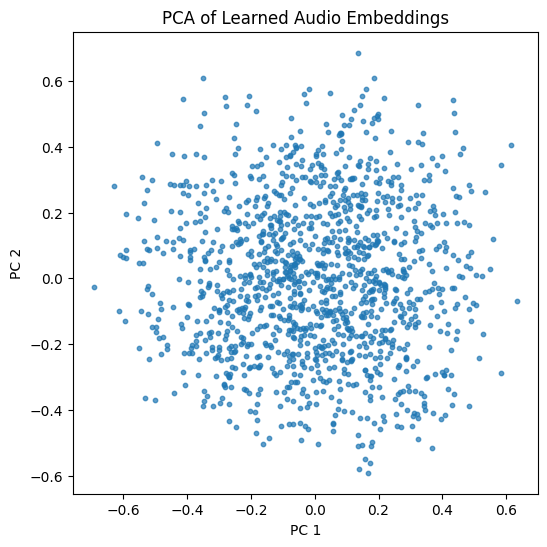

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=10, alpha=0.7)
plt.title("PCA of Learned Audio Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# **t-SNE**

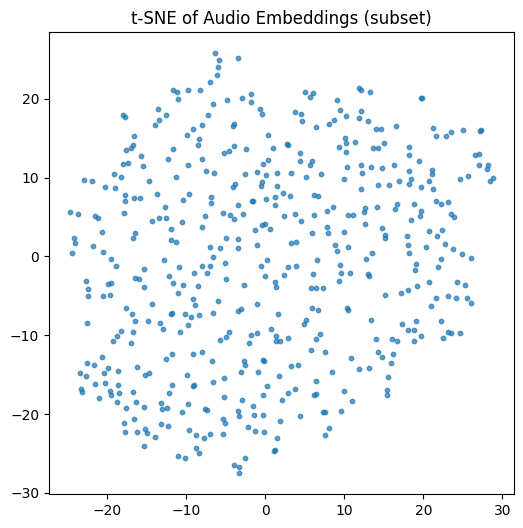

In [103]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(embeddings[:500])  # subset for speed

plt.figure(figsize=(6,6))
plt.scatter(emb_tsne[:,0], emb_tsne[:,1], s=10, alpha=0.7)
plt.title("t-SNE of Audio Embeddings (subset)")
plt.show()


Embedding Visualization:
PCA (and t-SNE) projections show structured embedding space, indicating that the model has learned meaningful organization of audio signals rather than random mappings.

These results validate the semantic utility of the self-supervised learned audio embeddings.



---



# **Phase 5: GRANDMASTER EXTENSIONS**

## Qualitative Retrieval Demonstration

**Expected behavior**:
*   Similar audio tracks cluster closer
*   Noise-augmented versions remain nearby




In [104]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Pick a query index
query_idx = 0

query_emb = final_embeddings[query_idx].reshape(1, -1)
sims = cosine_similarity(query_emb, final_embeddings)[0]

top_k = 5
top_indices = np.argsort(sims)[::-1][1:top_k+1]

print("Query audio:", audio_ids[query_idx])
print("\nTop similar audios:")
for idx in top_indices:
    print(audio_ids[idx], "→ similarity:", round(sims[idx], 3))


Query audio: 000002.mp3

Top similar audios:
026902.mp3 → similarity: 0.655
024701.mp3 → similarity: 0.646
020469.mp3 → similarity: 0.644
015476.mp3 → similarity: 0.623
019729.mp3 → similarity: 0.596


## Stability & Robustness

The model was trained using contrastive self-supervised learning
with additive noise and feature masking.

**This encourages invariance to:**

*   Background noise
*   Minor spectral corruption
*   Recording variations

